In [63]:
import pandas as pd
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import seaborn as sns
import useful_rdkit_utils as uru
from tqdm.auto import tqdm
from rdkit import Chem
from itertools import combinations
import matplotlib.ticker as ticker

A simple class to generate Morgan fingerprints from SMILES. 

In [7]:
class SmiFpGen:
    def __init__(self):
        self.mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

    def smi2fps(self,smi):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            return self.mfpgen.GetFingerprint(mol)
        else:
            return None

Instantiate a SmiFpGen object. 

In [10]:
smifpgen = SmiFpGen()

Calculate all pairs similarity for a set of SMILES

In [11]:
def cluster_stats(smi_list):
    fp_list = [smifpgen.smi2fps(x) for x in smi_list]
    sim_list = []
    for a,b in combinations(fp_list,2):
        sim_list.append(DataStructs.TanimotoSimilarity(a,b))
    return sim_list

Read the clustering results

In [42]:
df = pd.read_csv("cluster_comparison.csv.gz")

Create a summary of cluster sizes

In [43]:
cfp70_summary = uru.value_counts_df(df,"cfp70_cluster").head(100)
bb_summary = uru.value_counts_df(df,"bb_cluster").head(100)

In [44]:
cfp70_summary.rename(columns={"count": "cfp70_count"}, inplace=True)
bb_summary.rename(columns={"count": "bb_count"}, inplace=True)

Assemble the data for a plot

In [59]:
summary_df = pd.concat([cfp70_summary, bb_summary],axis=1)[["cfp70_count","bb_count"]]
summary_df['index'] = range(0,len(summary_df))
melt_df = summary_df.melt(id_vars=["index"])
melt_df.columns=["index","method","cluster_size"]

Plot the sizes of the 100 largest clusters

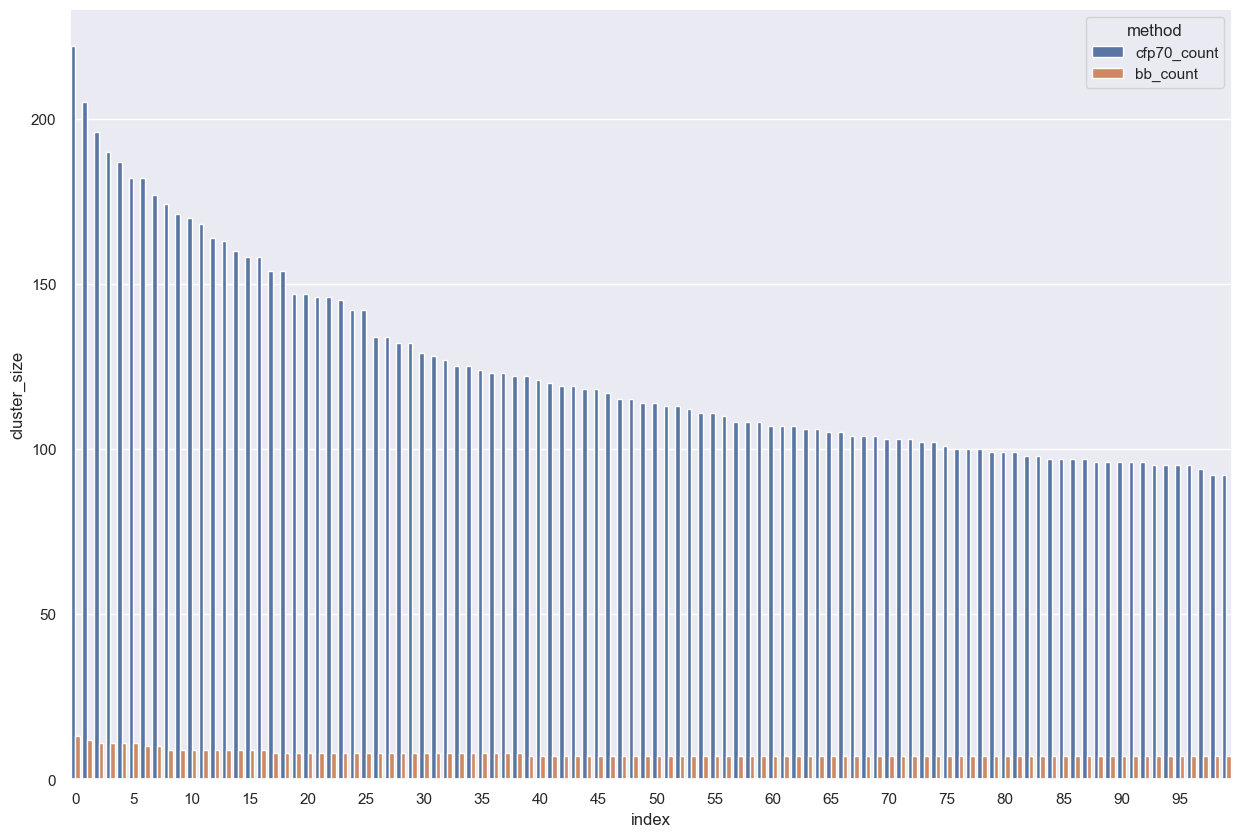

In [64]:
ax = sns.barplot(x="index",y="cluster_size",hue="method",data=melt_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

A function to plot boxplots of pairwise similarity for the 50 largest clusters

In [65]:
def plot_similarity_boxplots(df, column_name, num=50):
    top_cluster_list = uru.value_counts_df(df,column_name).head(num)[column_name].values
    df_list = [] 
    for idx,cluster_id in enumerate(tqdm(top_cluster_list)):
        query_str = f"{column_name} == {cluster_id}"
        smi_list = df.query(query_str).SMILES.values
        sim_list = cluster_stats(smi_list)
        sim_df = pd.DataFrame({"sim": sim_list})
        sim_df['idx'] = idx
        df_list.append(sim_df)
    combo_df = pd.concat(df_list)
    sns.set(rc={'figure.figsize': (15, 10)})
    ax = sns.boxplot(x="idx",y="sim",data=combo_df)
    ax.set_xlabel("Cluster Index (Largest First)")
    ax.set_ylabel("Tanimoto Similarity (Morgan FP)")  

Plot intracluster similarities for the 50 largest clusters from ChemFP/Butina. 

  0%|          | 0/50 [00:00<?, ?it/s]

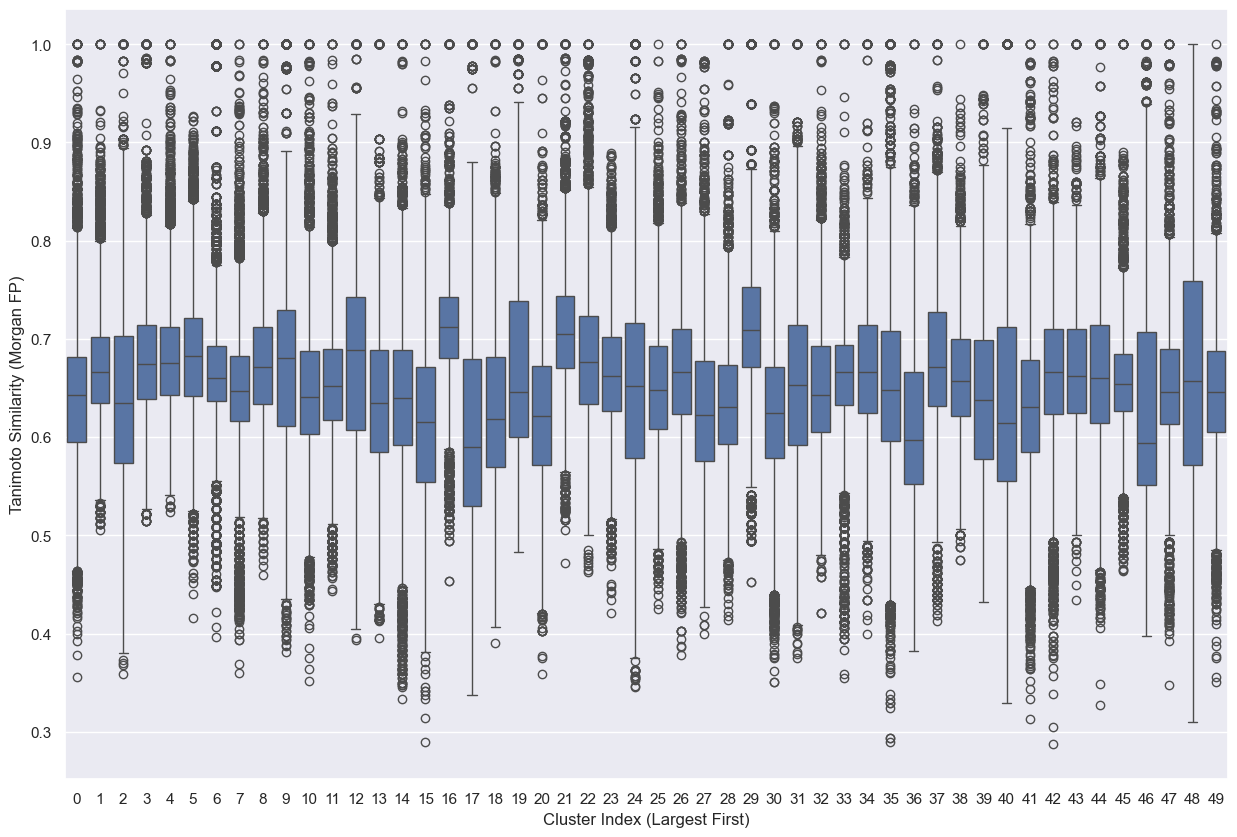

In [27]:
plot_similarity_boxplots(df,"cfp70_cluster",50)

Plot intracluster similarities for the 50 largest clusters from BitBirch.

  0%|          | 0/50 [00:00<?, ?it/s]

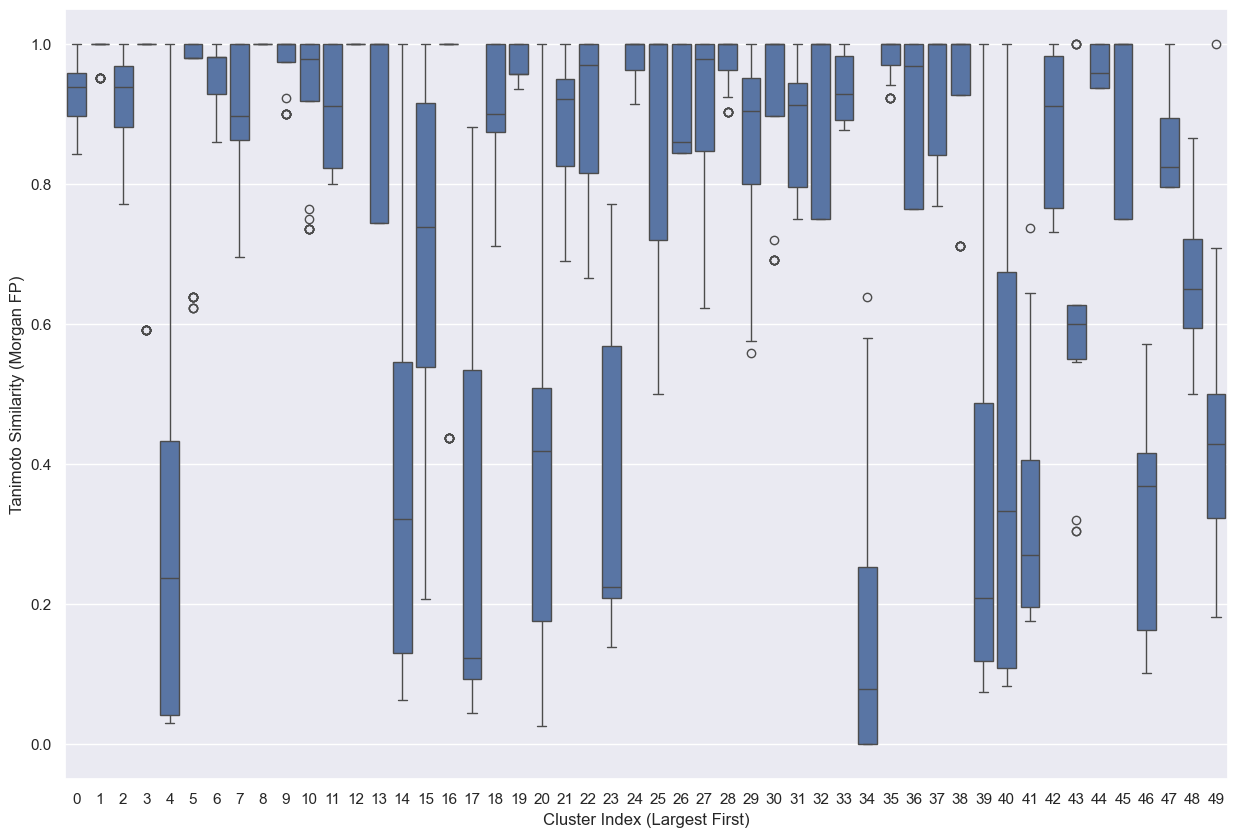

In [28]:
plot_similarity_boxplots(df,"bb_cluster",50)